# 3.线性回归模型

#### 3.1.1.4 小批量梯度下降
在每次需要计算更新的时候随机抽取一小批样本，进行小批量随机梯度下降

## 3.2 线性回归 手动实现

In [1]:
import random
import torch
from d2l import torch as d2l
%matplotlib inline

### 3.2.1 生成数据集

In [13]:
def synthetic_data(b, w, num_examples):
    X = torch.normal(0 ,1, (num_examples, len(w)))
    #返回一个张量,均值是0，平均数是1的正态分布
    y = torch.matmul(X, w) + b#这里不能用mm
    print(X.shape, w.shape)
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

In [15]:
true_b = 4.2
true_w = torch.tensor([2, -3.4])
features, labels = synthetic_data(true_b, true_w, 1000)


torch.Size([1000, 2]) torch.Size([2])


注意 features每一行都包含一个二维数据样本 labels每一行都包含一个标量

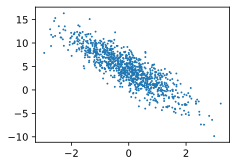

In [17]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

### 3.2.2 读取数据集


In [23]:
def data_iter(batch_size, featurs, labels):
    num_examples = len(featurs)
    indices = list(range(num_examples))
    #print(indices)
    random.shuffle(indices)#随机打乱列表中的元素
    #print(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i : min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [24]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.0718, -1.4771],
        [-0.0112, -0.6983],
        [ 1.4385, -0.0880],
        [-0.0851, -1.0240],
        [ 1.2374, -0.6048],
        [ 0.1956,  0.1081],
        [-0.5784, -0.6976],
        [-1.0212,  1.0230],
        [ 1.0374, -0.2737],
        [-0.0291,  0.4537]]) 
 tensor([[11.3709],
        [ 6.5463],
        [ 7.3956],
        [ 7.4965],
        [ 8.7551],
        [ 4.2202],
        [ 5.4162],
        [-1.3195],
        [ 7.2120],
        [ 2.6056]])


### 3.2.3 初始化模型参数

In [25]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

### 3.2.4 定义线性回归模型

In [26]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

### 3.2.5定义损失函数

In [27]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

### 3.2.6定义优化算法

In [28]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### 3.2.7训练

In [29]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.027126
epoch 2, loss 0.000096
epoch 3, loss 0.000050


In [30]:
print(w, b)

tensor([[ 2.0006],
        [-3.4002]], requires_grad=True) tensor([4.2001], requires_grad=True)


## 3.3借助Pytorch实现线性回归

### 3.3.1 生成数据集

In [6]:
import numpy as np
import torch 
from torch.utils import data 
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### 3.3.2 读取数据集
调用匡建中现有的API来读取数据。将features labels作为API的参数，在实例化数据迭代器对象的时候指定batch_size,此外，is_train表示是否希望数据迭代器对象在每个迭代周期内打乱数据

In [10]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)
next(iter(data_iter))

[tensor([[ 0.3993, -0.6599],
         [-2.3855,  0.7267],
         [-1.2671, -0.0636],
         [-0.2664, -0.7485],
         [-0.7159, -1.8766],
         [-1.8073,  2.4996],
         [-0.3637,  0.3290],
         [ 1.0321, -1.5063],
         [-1.0046, -1.1364],
         [ 0.8412,  0.1740]]),
 tensor([[ 7.2551],
         [-3.0496],
         [ 1.8664],
         [ 6.2188],
         [ 9.1565],
         [-7.9083],
         [ 2.3615],
         [11.3784],
         [ 6.0600],
         [ 5.3033]])]

### 3.3.3 定义模型

In [20]:
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))
#定义全连接层nn.Linear
#2是输入的特征形状
#1是输出特征形状

### 3.3.4初始化模型参数
- 通过net[0]选择网络中的第一个图层
- 使用weight.data bias.data方法访问参数
- 用替换方法normal_ fill_来重写参数值

In [21]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 3.3.5 定义损失函数

In [22]:
loss = nn.MSELoss()

### 3.3.6 定义优化算法
- SGD实现小批量梯度下降

In [23]:
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### 3.3.7 训练
其主要步骤如下：
- 通过调用net(X) 生成预测并计算损失l(正向传播)
- 通过进行反向传播来啊计算梯度
- 通过调用优化器来更新模型参数

In [24]:
num_epochs = 3
print(net[0].weight)
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        #每次计算之前梯度清零，不要让之前的梯度影响了现在的计算
        l.backward()
        trainer.step()#更新所有的参数
        print(net[0].weight)
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

Parameter containing:
tensor([[-0.0058,  0.0003]], requires_grad=True)
Parameter containing:
tensor([[ 0.2460, -0.2219]], requires_grad=True)
Parameter containing:
tensor([[ 0.3177, -0.6706]], requires_grad=True)
Parameter containing:
tensor([[ 0.3767, -0.6132]], requires_grad=True)
Parameter containing:
tensor([[ 0.7215, -0.9430]], requires_grad=True)
Parameter containing:
tensor([[ 0.8018, -1.0104]], requires_grad=True)
Parameter containing:
tensor([[ 0.8258, -1.1395]], requires_grad=True)
Parameter containing:
tensor([[ 0.9349, -1.1967]], requires_grad=True)
Parameter containing:
tensor([[ 1.0059, -1.3279]], requires_grad=True)
Parameter containing:
tensor([[ 1.0378, -1.3744]], requires_grad=True)
Parameter containing:
tensor([[ 1.1992, -1.5459]], requires_grad=True)
Parameter containing:
tensor([[ 1.2156, -1.8398]], requires_grad=True)
Parameter containing:
tensor([[ 1.2338, -1.9270]], requires_grad=True)
Parameter containing:
tensor([[ 1.2576, -1.9841]], requires_grad=True)
Parame

In [17]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([ 2.6405e-04, -5.9366e-05])
b的估计误差： tensor([-0.0007])
